In [1]:
import pandas as pd

In [2]:
url = 'https://storage.gra.cloud.ovh.net/v1/AUTH_32c5d10cb0fe4519b957064a111717e3/bso_dump/bso-clinical-trials.jsonl.gz'
df = pd.read_json(url, lines=True)

In [11]:
mapping = pd.read_csv('https://raw.githubusercontent.com/dataesr/bso-clinical-trials/main/bsoclinicaltrials/server/main/bso-lead-sponsors-mapping.csv')

In [353]:
len('01kv58h76')

9

In [356]:
list_rors = [r.split('/')[-1] for r in mapping.ror.unique() if (r==r) and len(r.split('/')[-1])==9]
len(list_rors)

101

In [71]:
df_completed_intervention = df[(df.status_simplified=='Completed') & (df.study_type=='Interventional')]

df2 = df_completed_intervention[['lead_sponsor', 'study_completion_year', 'NCTId', 'eudraCT', 'study_type', 
                                 'status_simplified',
    'has_results_or_publications', 'has_results_or_publications_within_1y', 'has_results_or_publications_within_3y']]

In [72]:
dd = pd.merge(df2, mapping, left_on='lead_sponsor', right_on='sponsor', indicator=True, how='inner')

In [73]:
dd._merge.value_counts()

both          7641
left_only        0
right_only       0
Name: _merge, dtype: int64

In [74]:
#dd[dd._merge=='left_only'].lead_sponsor.value_counts().head(50)

In [75]:
dd_ror = dd[dd.ror.apply(lambda x:isinstance(x, str) and 'ror.org/' in x)]

In [76]:
dd_ror['ror_simple'] = dd_ror.ror.apply(lambda x:x.split('/')[-1])

<ipython-input-76-c7b3ad7a3353>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd_ror['ror_simple'] = dd_ror.ror.apply(lambda x:x.split('/')[-1])


In [77]:
# APHP 00pg5jh14 
# IPC 04s3t1g37

In [78]:
current_ror = '00pg5jh14'

In [259]:
len(df_etab)

888

In [82]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
SIZE = 22
SMALL_SIZE=18
plt.rc('font', size=SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE)    # legend fontsize
plt.rc('figure', titlesize=SIZE)  # fontsize of the figure title  

In [191]:
def analyze_global(df_etab):
    ans = {'global': {}, '10Y': {}}
    
    d_g = pd.DataFrame(df_etab.has_results_or_publications.value_counts(dropna=False))
    d_g_10 = pd.DataFrame(df_etab[df_etab.study_completion_year >= 2013].has_results_or_publications.value_counts(dropna=False))
    
    cle_false = 'SANS communication\nidentifiée'
    cle_true = 'AVEC communication\nidentifiée'
    
    ans['global'][cle_true] = d_g[d_g.index==True].has_results_or_publications.values[0]
    ans['global'][cle_false] = d_g[d_g.index==False].has_results_or_publications.values[0]

    assert(ans['global'][cle_false] + ans['global'][cle_true]) == len(df_etab)
    

    
    ans['10Y'][cle_true] = d_g_10[d_g_10.index==True].has_results_or_publications.values[0]
    ans['10Y'][cle_false] = d_g_10[d_g_10.index==False].has_results_or_publications.values[0]
    
    return ans


In [342]:
def make_evolution(ror, df_tmp):
    
    df1Y = pd.DataFrame(df_tmp[(df_tmp.study_completion_year>=2014) & (df_tmp.study_completion_year<2023)]\
    .groupby('study_completion_year')['has_results_or_publications_within_1y', ].mean()).reset_index()
    df3Y = pd.DataFrame(df_tmp[(df_tmp.study_completion_year>=2014) & (df_tmp.study_completion_year<2021)]\
    .groupby('study_completion_year')['has_results_or_publications_within_3y', ].mean()).reset_index()
    df1_3Y = pd.merge(df1Y, df3Y, on='study_completion_year', how='left')
    years = df1_3Y.study_completion_year.tolist()
    rate1Y = df1_3Y.has_results_or_publications_within_1y.tolist()
    rate3Y = df1_3Y.has_results_or_publications_within_3y.tolist()
    rate3Y = [r for r in rate3Y if r==r]
    
    fig, ax = plt.subplots(figsize=(9,9), dpi=100)

    width = 0.25  # the width of the bars
    multiplier = 0

    offset1 = width * multiplier
    rects1 = ax.bar([y-0.1 for y in years], [100 * r for r in rate1Y], width, label='1 an')
    ax.bar_label(rects1, labels = [f'{round(100*r)} %' for r in rate1Y], padding=3, fontsize=SMALL_SIZE)

    multiplier = 1
    offset2 = width * multiplier
    rects2 = ax.bar([y+0.1 for y in years[0:len(rate3Y)]], [100 * r for r in rate3Y], width, label='3 ans')
    ax.bar_label(rects2, labels = [f'{round(100*r)} %' for r in rate3Y], padding=3, fontsize=SMALL_SIZE)



    # Add some text for labels, title and custom x-axis tick labels, etc.
    #ax.set_ylabel('Length (mm)')
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    #ax.set_title('Penguin attributes by species')
    ax.set_xticks(years)
    ax.set_xticklabels([str(y).replace('.0', '') for y in years], rotation='vertical', fontsize=SMALL_SIZE)
    ax.legend(loc='upper left')
    ax.set_xlabel("Année de clôture de l'essai clinique")

    ax.set_ylim(0, min(100, max(rate3Y)*100+15))

    plt.savefig(f"./../publipostage/{ror}/evolution_temporelle_essais_cliniques_{ror}.png", bbox_inches="tight", dpi=300)

In [343]:
import os

def make_data(ror):
    os.system(f"mkdir -p ./../publipostage/{ror}")
    df_tmp = dd_ror[dd_ror.ror_simple == ror]
    df_tmp.to_csv(f'./../publipostage/{ror}/liste_essais_cliniques_identifies_{ror}.csv', index=False)
    stats = analyze_global(df_tmp)
    make_pie(ror, stats, 'global')
    make_pie(ror, stats, '10Y')
    make_evolution(ror, df_tmp)

def make_pie(ror, stats, pie_type):
    
    fig, ax = plt.subplots(figsize=(9,9), dpi=100)
    values = list(stats[pie_type].values())
    labels_raw=list(stats[pie_type].keys())
    total = values[0] + values[1]
    labels = [f'{values[0]} essais cliniques sur {total}\nSANS communication identifiée',
             f'{values[1]} essais cliniques sur {total}\nAVEC communication identifiée']

    colors=['#FFF5BA', '#5A35BE']

    _, _, autotexts  = ax.pie(values, startangle=90, autopct='%1.0f%%', 
                 explode=(0.025, 0.025),
                 colors=colors)

    autotexts[1].set_color('white')

    ax.legend(labels=labels, bbox_to_anchor=(0.15,0.5), 
              loc="center right", fontsize=20, 
               bbox_transform=plt.gcf().transFigure)

    
    plt.savefig(f"./../publipostage/{ror}/repartition_essais_cliniques_{pie_type}_{ror}.png", bbox_inches="tight", dpi=300)


01kv58h76
002cp4060
035xkbk20


IndexError: index 0 is out of bounds for axis 0 with size 0

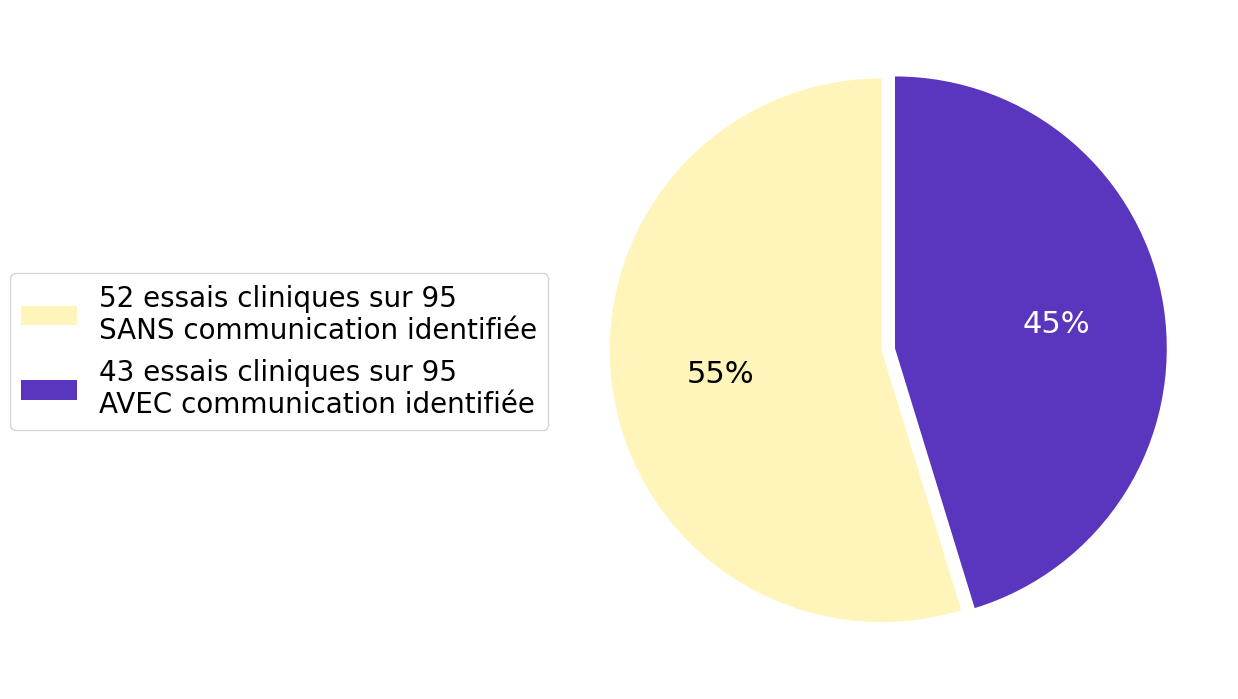

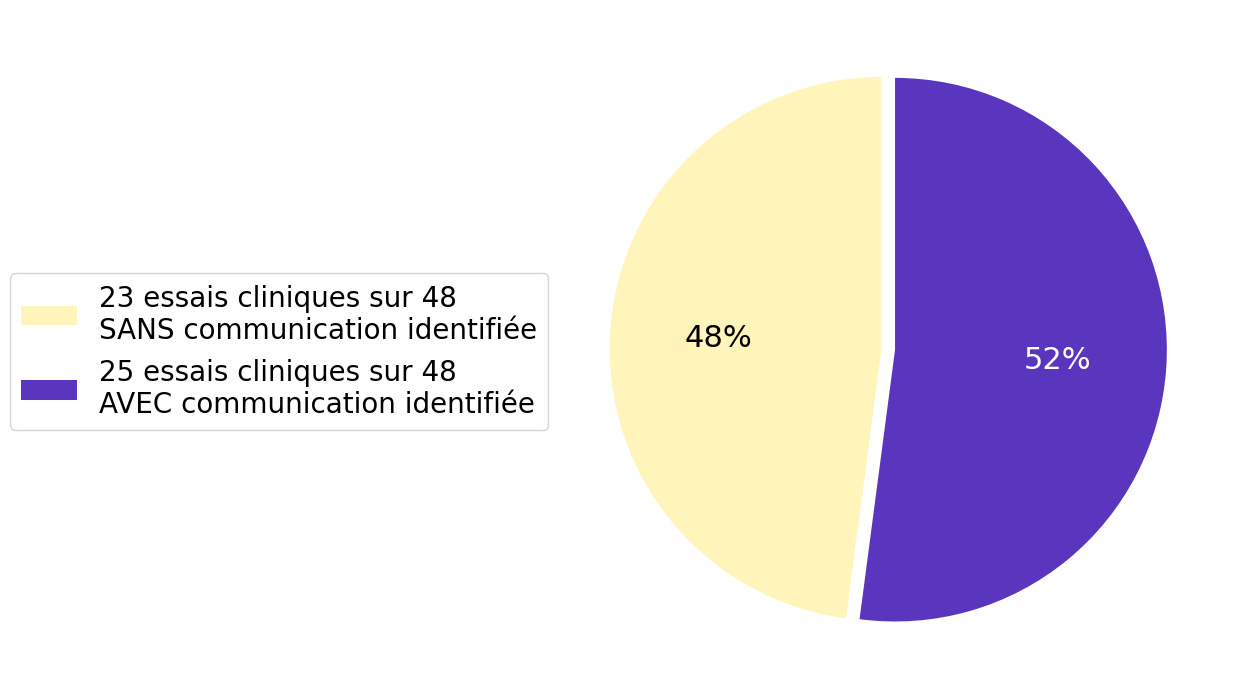

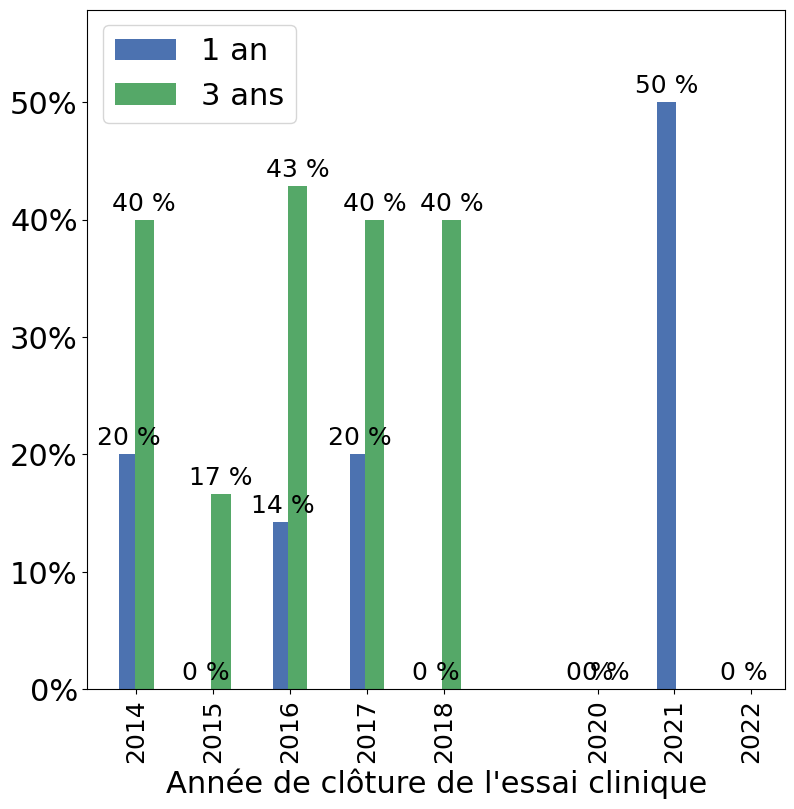

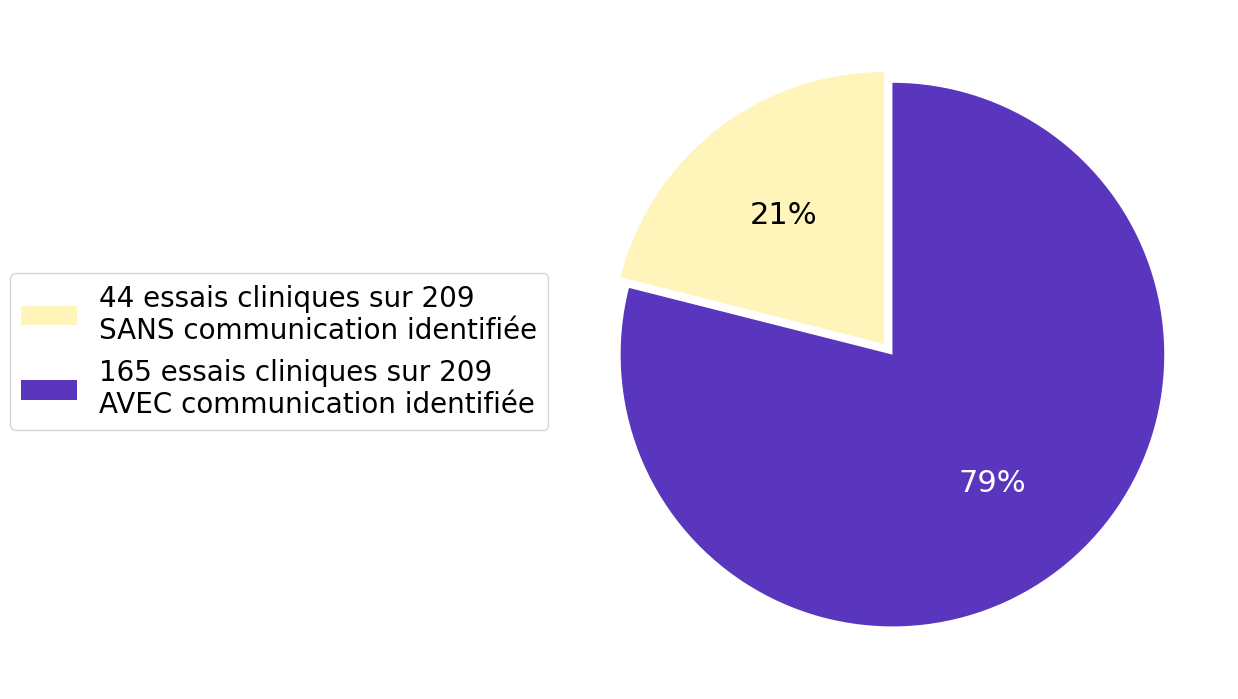

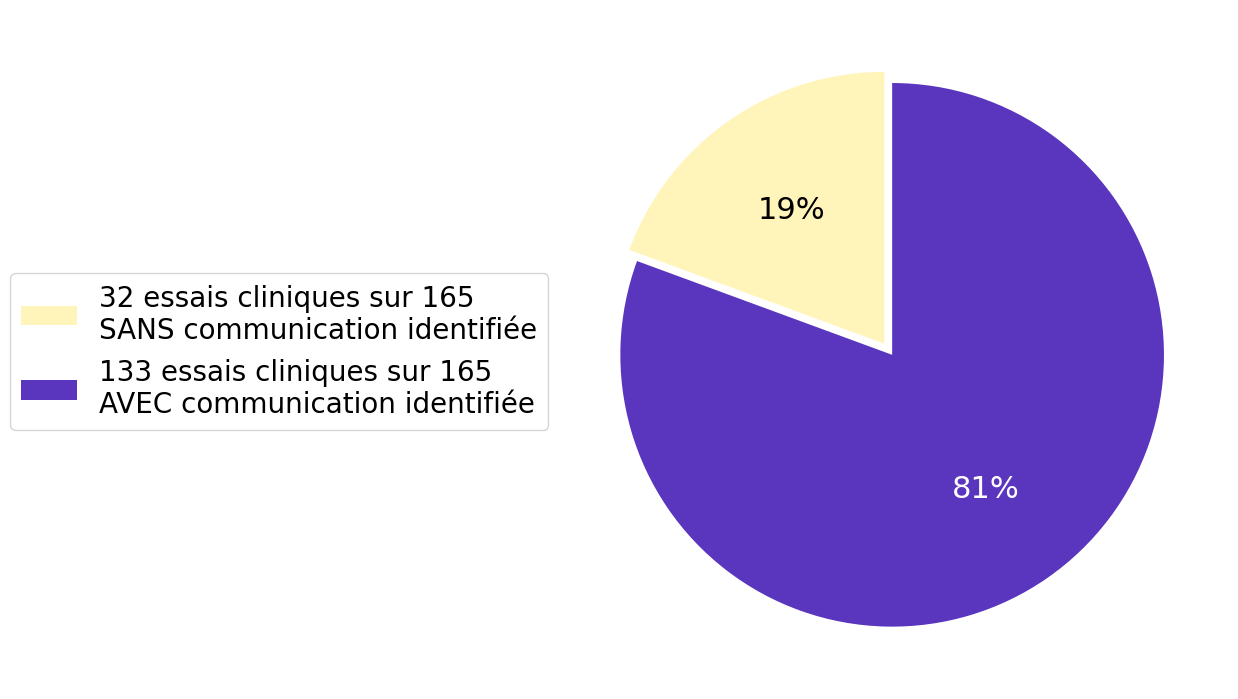

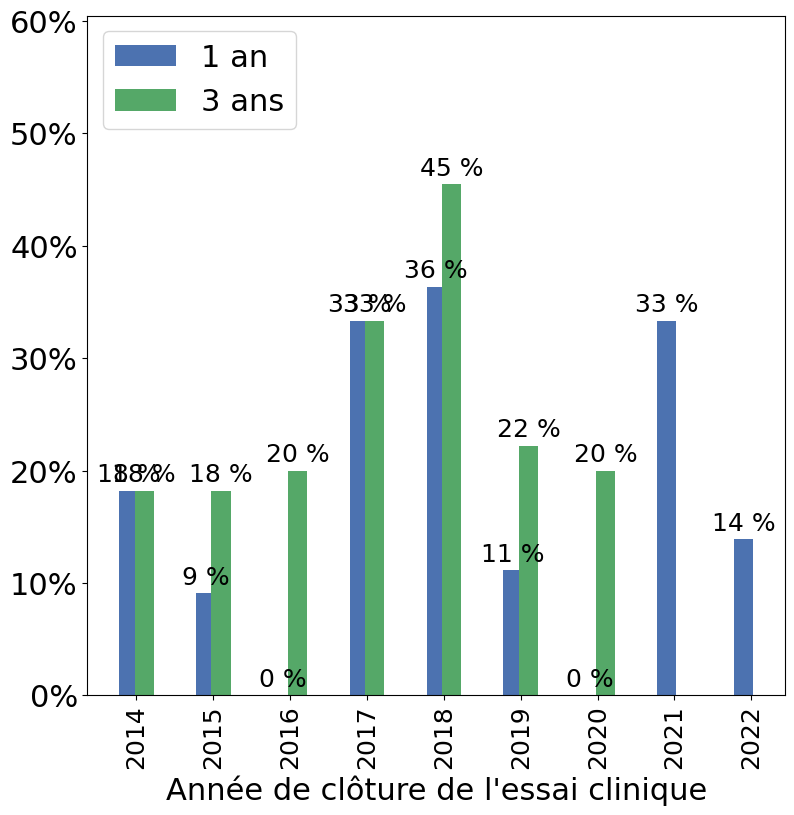

In [357]:
for current_ror in list_rors:
    print(current_ror)
    make_data(current_ror)
#make_data('04s3t1g37')